In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import seaborn as sns

In [2]:
plt.rcParams['figure.figsize']=[5,4]

In [3]:
df = pd.read_csv("../data/Cleaned_data.csv")

In [4]:
df.head()

,Sensor-1,Sensor-2,Sensor-3,Sensor-4,Sensor-5,Sensor-7,Sensor-8,Sensor-9,Sensor-10,Sensor-11,...,Sensor-578,Sensor-583,Sensor-584,Sensor-585,Sensor-586,Sensor-587,Sensor-588,Sensor-589,Sensor-590,Good/Bad
0,3076.81,NaN,2208.2334,1517.0152,1.0980,110.1900,0.1247,1.4357,0.0089,0.0052,...,9.5549,0.5016,0.0152,0.0040,3.0319,NaN,0.0299,0.0090,64.2405,-1
1,2951.62,2511.92,NaN,1397.5060,0.9660,109.7611,0.1210,1.5527,0.0119,-0.0082,...,11.2721,0.4953,0.0105,0.0037,2.1266,NaN,0.0252,0.0081,NaN,-1
2,2930.42,2505.17,2235.0556,1302.6607,1.6347,109.9856,0.1230,1.4588,-0.0143,0.0017,...,NaN,0.4958,0.0111,0.0033,2.2296,NaN,0.0252,0.0081,NaN,-1
3,2997.28,NaN,NaN,1236.5212,0.9698,98.3344,0.1238,NaN,NaN,NaN,...,19.5919,0.4962,NaN,NaN,NaN,NaN,0.0252,0.0081,NaN,-1
4,3025.10,2475.18,2235.0556,1302.6607,1.6347,109.9856,0.1230,1.5525,-0.0078,-0.0005,...,10.8826,0.4983,0.0159,0.0041,3.1927,NaN,0.0252,0.0081,NaN,-1


In [5]:
df.shape

(1537, 433)

In [6]:
with open("../artifacts/valid_features.txt") as file:
    valid_features = file.readlines()

valid_features = [line.strip() for line in valid_features]
target = "Good/Bad"

In [7]:
# dataset is imbalanced
df[target].value_counts()

Good/Bad
-1    1448
 1      89
Name: count, dtype: int64

Since there is very high imbalance in data, having a test data for validation would not be representative and is very likely to overfit.

The better choice is to cross validate on the data and choose the best model

The imbalance in the dataset should be taken care of by oversampling.

In [8]:
X_train = df[valid_features]
y_train = df[target]

In [9]:
preprocessor = Pipeline(
    steps=[
        ('scaler', RobustScaler()),       
        ('imputer', KNNImputer()),
    ]
)

pca = PCA(n_components=0.95, random_state=55)
oversampler = SMOTE(sampling_strategy=0.33, random_state=44)

X_train = preprocessor.fit_transform(X_train)
X_train , y_train = oversampler.fit_resample(X_train, y_train)
X_train = pca.fit_transform(X_train)

# label encoding the target to be consistent with the metrics
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [10]:
pca.explained_variance_ratio_[:15]

array([0.1415554 , 0.11665411, 0.11055132, 0.07843091, 0.02339346,
       0.02018185, 0.01663465, 0.01505062, 0.0119582 , 0.01107837,
       0.01019571, 0.00977773, 0.00896907, 0.0088089 , 0.0083313 ])

<Axes: >

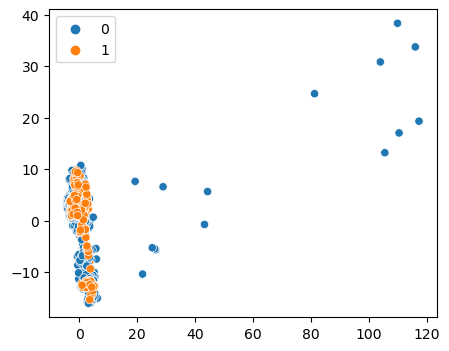

In [11]:
sns.scatterplot(x=X_train[:,0], y=X_train[:,1], hue=y_train)

Plotting with the top components after PCA which explain the most variance.

There does not seem to be any indication of strong patterns in the data

In [11]:
X_train.shape, y_train.shape

((1925, 161), (1925,))

Clustering

In [13]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [14]:
import warnings
warnings.filterwarnings('ignore')

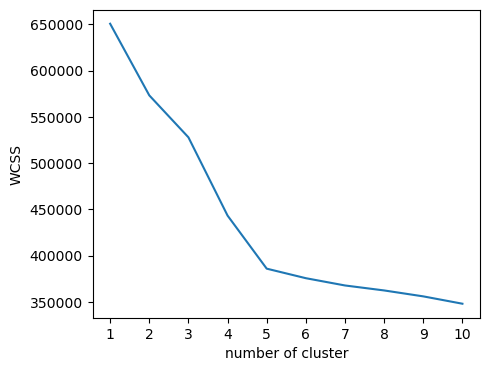

In [15]:
wcss=[]
for k in range(1,11):
    kmean=KMeans(n_clusters=k, random_state=10)
    kmean.fit(X_train)
    wcss.append(kmean.inertia_)
    

sns.lineplot(y=wcss, x=range(1,11))
plt.xticks(range(1,11))
plt.xlabel("number of cluster")
plt.ylabel("WCSS")
plt.show()

In [16]:
silhouette_coefficients=[]
for i in range(2,11):
    kmeans=KMeans(n_clusters=i, random_state=5)
    kmeans.fit(X_train)
    score=silhouette_score(X_train,kmeans.labels_)
    silhouette_coefficients.append(score)

silhouette_coefficients

[0.32316839001349246,
 0.20986759484237763,
 0.20485366131273255,
 0.2212053807627225,
 0.1113835351062098,
 0.10751205213254249,
 0.07075106913777506,
 0.06216879732897846,
 0.060484704939420895]

Clustering is not well defined suggesting that the data may not be well separated.

In [17]:
from kneed import KneeLocator
elbow = KneeLocator(range(1,11), wcss, curve='convex', direction='decreasing')
elbow.elbow

5

In [19]:
clustering = KMeans(n_clusters=5, random_state=5)
clustering.fit(X_train)

unique,counts = np.unique(clustering.labels_, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0  172]
 [   1  327]
 [   2  178]
 [   3    7]
 [   4 1241]]


GMM

In [18]:
scores = list()

for i in range(2,11):
    clustering = GaussianMixture(n_components=i, random_state=10)
    labels=clustering.fit_predict(X_train)
    score=silhouette_score(X_train,labels)
    scores.append({'n_clusters':i, 'score':score})

scores

[{'n_clusters': 2, 'score': 0.19450604201978977},
 {'n_clusters': 3, 'score': 0.21470239475907568},
 {'n_clusters': 4, 'score': 0.20371394623548636},
 {'n_clusters': 5, 'score': 0.2212053807627225},
 {'n_clusters': 6, 'score': 0.10753912712577084},
 {'n_clusters': 7, 'score': 0.10522169121680826},
 {'n_clusters': 8, 'score': 0.09435949952310625},
 {'n_clusters': 9, 'score': 0.09726989657178792},
 {'n_clusters': 10, 'score': 0.09785130002412605}]

Clustering might not be the right approach since the clusters are not well defined

The data doesn't have well defined boundaries to cluster and train different models for each cluster.

The dimension of the dataset is large that distance metrics become less efficent.

Model Training

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score,f1_score,roc_auc_score,ConfusionMatrixDisplay

In [13]:
from dataclasses import dataclass

# parameters have been chosen so as to reduce overfitting too.
@dataclass
class modelParams:

    LogisticRegression_params ={
        'penalty':['l1', 'l2'],
        'C':[0.01, 0.1, 1, 10]
    }


    SVC_params = {
        'kernel' : ['linear', 'rbf'],
        'C': [0.1, 0.5, 0.7],
    }


    randomForest_params = {
        'n_estimators': [100, 200],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 3, 5],
        'min_samples_split': [3, 5],
        'min_samples_leaf': [2],
        'max_features': ['sqrt', 'log2']
    }


    xgboost_params = {
        'learning_rate': [0.3, 0.2, 0.1],
        'max_depth': [2, 3, 4],
        'n_estimators': [150, 100],
        'colsample_bytree' : [0.5],
        'reg_alpha' : [5],
        'reg_lambda' : [5]
        
    }

In [18]:
class model_finder:
    
    def __init__(self, X_train, y_train) -> None:
        self.X_train = X_train
        self.y_train = y_train
        self.params = modelParams()

    def find_logistic_regression(self) -> LogisticRegression:
        model = LogisticRegression(solver='liblinear', class_weight='balanced')
        model_Grid = GridSearchCV(estimator=model, param_grid=self.params.LogisticRegression_params, 
                            scoring='f1', verbose=2)
        
        model_Grid.fit(self.X_train, self.y_train)
        return model_Grid
    
    def find_SVC(self):
        model = SVC(class_weight='balanced')
        model_Grid = GridSearchCV(estimator=model, param_grid=self.params.SVC_params, 
                            scoring='f1', verbose=2)

        model_Grid.fit(self.X_train, self.y_train)
        return model_Grid
    
    def find_randomForest(self):
        model = RandomForestClassifier(random_state=5, class_weight='balanced')
        model_Grid = GridSearchCV(estimator=model, param_grid=self.params.randomForest_params, 
                            scoring='f1', verbose=2)

        model_Grid.fit(self.X_train, self.y_train)
        return model_Grid
    
    def find_xgboost(self):
        model = XGBClassifier(objective="binary:logistic")
        model_Grid = GridSearchCV(estimator=model, param_grid=self.params.xgboost_params, 
                            scoring='f1', verbose=2)

        model_Grid.fit(self.X_train, self.y_train)
        return model_Grid

In [19]:
model_finder = model_finder(X_train, y_train)
results = {
    "Logistic Regression" : model_finder.find_logistic_regression(),
    "SVC" : model_finder.find_SVC(),
    "Random Forest" : model_finder.find_randomForest(),
    "XGBoost" : model_finder.find_xgboost()
}

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.1s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1,

Model: Logistic Regression
f1 score: 0.7180320454435417
Balanced Accuracy: 0.9234909424696248
Roc Auc Score: 0.9234909424696248

--------------------------------------------------

Model: SVC
f1 score: 0.918187996407449
Balanced Accuracy: 0.9941052213998633
Roc Auc Score: 0.9941052213998635

--------------------------------------------------

Model: Random Forest
f1 score: 0.9324671195259431
Balanced Accuracy: 1.0
Roc Auc Score: 1.0

--------------------------------------------------

Model: XGBoost
f1 score: 0.9560954897875893
Balanced Accuracy: 0.9989517819706499
Roc Auc Score: 0.9989517819706499

--------------------------------------------------



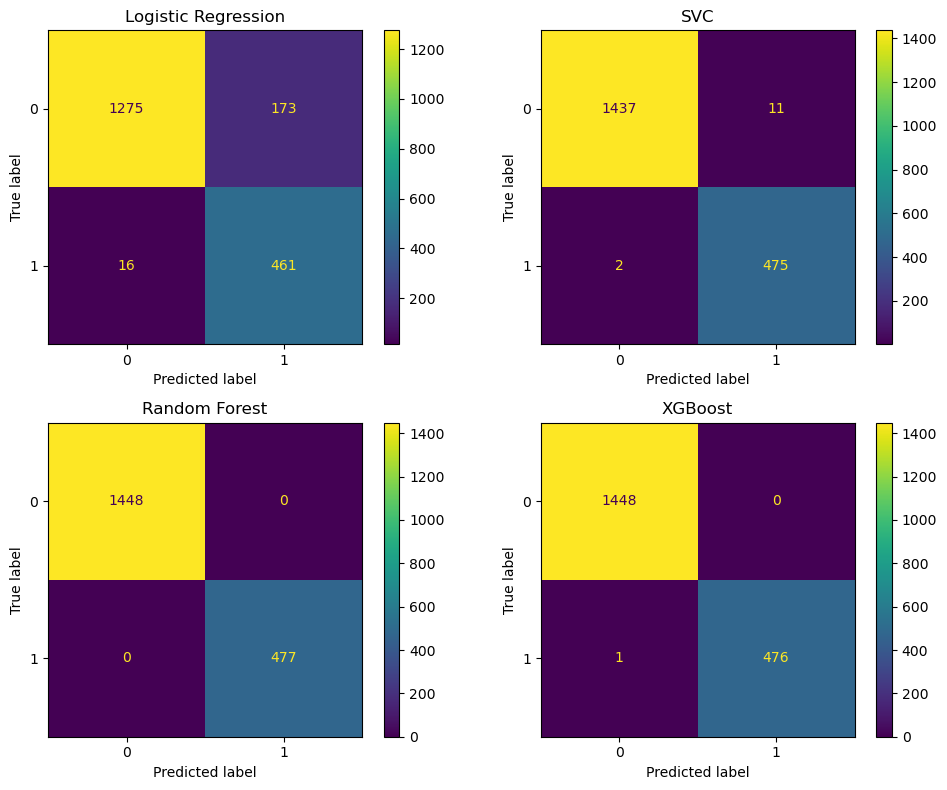

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(10,8))
axes = axes.flatten()

for i,name in enumerate(results):
    best_model = results.get(name)
    y_pred = best_model.best_estimator_.predict(X_train)
    f1 = best_model.best_score_
    balanced_accuracy = balanced_accuracy_score(y_train, y_pred)
    rocAuc = roc_auc_score(y_train, y_pred)

    print(f"Model: {name}")
    #print(f"Best Parameters: {best_model.best_params_}")
    #print(f"\nTraining Accuracy: {best_model.best_score_*100}")
    print(f"f1 score: {f1}")
    print(f"Balanced Accuracy: {balanced_accuracy}")
    print(f"Roc Auc Score: {rocAuc}")
    print("\n","-"*50,"\n", sep="")

    ConfusionMatrixDisplay.from_predictions(y_train, y_pred, labels=best_model.best_estimator_.classes_, ax=axes[i])
    axes[i].set_title(name)

plt.tight_layout()

XGBoost performed the best in cross validation